In [3]:
import os
from glob import glob

dir_path = "/content/drive/Shareddrives/Deep_Learning_A3/Datasets"

image_files = glob(os.path.join(dir_path, '**/*.jpg'), recursive=True) + \
              glob(os.path.join(dir_path, '**/*.jpeg'), recursive=True) + \
              glob(os.path.join(dir_path, '**/*.png'), recursive=True)

total_images = len(image_files)

print("Total number of images:", total_images)


Total number of images: 2748


In [4]:
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split

In [7]:
from keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small

In [5]:
# This functions extract the images from all the subfolders in ImageClassification and put it in an array
def load_data(data_dir):
    images = []
    labels = [] 
    class_names = sorted(os.listdir(data_dir))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name) 
        for file_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, file_name) 
            image = Image.open(image_path) 
            target_size = (224,224) # Resize the image to 224 * 224
            image = image.resize(target_size)
            image = np.array(image)
            image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0
            images.append(image) 
            labels.append(class_index) 
    images = np.array(images)
    labels = np.array(labels)
    print(class_names)
    return images, labels, class_names

In [8]:
path='/content/drive/Shareddrives/Deep_Learning_A3/Datasets'
images, labels, class_names = load_data(path)

['Central_Station', 'Centre_Park', 'Chinatown', 'Darling_Harbour', 'Darling_Square_Alley', 'Darling_Square_FoodCourt', 'Harbour_Bridge', 'Haymarket', 'Market_City', 'Opera_House', 'QVB', 'UTSB2', 'UTSLIGHTS']


In [24]:
print(np.shape(images)) #look at the dimension of the dataset
print(len(labels))

(2748, 224, 224, 3)
2748


In [ ]:
# from tensorflow.keras.utils import to_categorical

# # Convert labels to one-hot encoding
# labels = to_categorical(labels, num_classes=13)
# print(labels.shape)

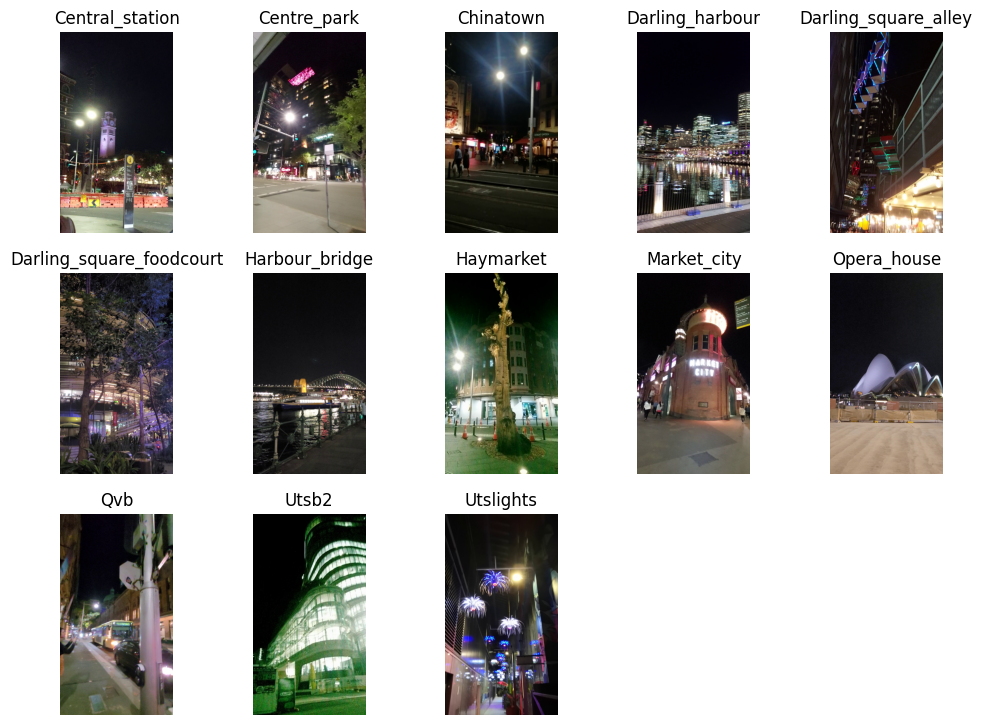

In [9]:
import matplotlib.pyplot as plt

# get the list of all subfolders
subfolders = sorted(os.listdir(path))

# create a figure object
fig = plt.figure(figsize=(12, 12))

# loop through all subfolders
for i, subfolder in enumerate(subfolders):
    # get the label name from the subfolder name
    label = subfolder.capitalize()  # assuming the subfolder name is in lowercase
    
    # get the path of all images in the subfolder
    img_paths = os.listdir(os.path.join(path, subfolder))
    
    # select the first image from the subfolder
    img_path = os.path.join(path, subfolder, img_paths[0])
    
    # load the image using PIL
    img = Image.open(img_path)
    
    # add the image to the figure
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img)
    ax.axis('off')
    
    # add the label to the image
    ax.set_title(label)

# display the figure
plt.show()

In [ ]:
import numpy as np
from collections import Counter
from sklearn.utils import shuffle

def undersample(images, labels):
    # calculate the average number of instances per class
    class_counts = Counter(labels)
    average_count = np.mean(list(class_counts.values()))

    # create a mapping of class labels to indices in the data array
    class_indices = {}
    for label in class_counts.keys():
        class_indices[label] = np.where(labels == label)[0]

    # randomly select instances to remove for each class with more instances than the average
    for label, indices in class_indices.items():
        count = len(indices)
        if count > average_count:
            indices_to_remove = np.random.choice(indices, size=int(count - average_count), replace=False)
            images = np.delete(images, indices_to_remove, axis=0)
            labels = np.delete(labels, indices_to_remove)

    # shuffle the data to ensure randomness
    images, labels = shuffle(images, labels)

    return images, labels


In [ ]:
images, labels = undersample(images, labels)

In [ ]:
def count_instances(labels):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    return class_counts

In [ ]:
class_counts = count_instances(labels)
print(class_counts)

{0: 225, 1: 231, 2: 186, 3: 106, 4: 70, 5: 285, 6: 122, 7: 113, 8: 134}


In [10]:
# Split the training set into training and training sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42, stratify = labels)

# Split the training set into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify = y_test)

In [ ]:
X_train.shape

(883, 224, 224, 3)

In [11]:
# Check the size of the training, test, and validation set
print(len(X_train), len(X_test), len(X_val))

1648 550 550


In [ ]:
# # Image augmentation settings for the training set
# train_datagen = ImageDataGenerator(
#       rescale=1./255, # Normalisation
#       rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest') #perform image augmentation

# test_datagen =  ImageDataGenerator(rescale=1./255) # Normalisation

# batch_size = 8

# # Flow training images using train_datagen generator
# train_generator = train_datagen.flow(
#          X_train, y_train,
#         batch_size=batch_size)

# # Flow test images using test_datagen generator
# test_generator = test_datagen.flow(
#          X_test, y_test,
#         batch_size=batch_size)

# # Flow validation images using test_datagen generator
# validation_generator = test_datagen.flow(
#          X_val, y_val,
#         batch_size=batch_size)

In [12]:
from keras.regularizers import l1_l2

pretrained_model = MobileNetV3Small(input_shape=(224,224,3), classes=13,
                             weights="imagenet", pooling=None, include_top=False)

# set all layers trainable because when I froze most of the layers the model didn't learn so well
for layer in pretrained_model.layers:
    layer.trainable = True
last_output = pretrained_model.layers[-1].output
x = GlobalMaxPooling2D()(last_output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
x = Dense(13, activation='softmax', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
model = Model(pretrained_model.input, x)

model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
filepath = '/content/drive/Shareddrives/Deep_Learning_A3/Weights/MobileNetV3Small/weights.{epoch:02d}-{val_loss:.2f}.hdf5' #2 decimal point for epoch .hdf5 the format it is stored'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode= 'auto', period=1)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size= 8
)

Epoch 1/50
206/206 [==============================] - 10s 42ms/step - loss: 93.8909 - accuracy: 0.9175 - val_loss: 94.0530 - val_accuracy: 0.0945
Epoch 2/50
206/206 [==============================] - 8s 41ms/step - loss: 88.8808 - accuracy: 0.9272 - val_loss: 89.1788 - val_accuracy: 0.1291
Epoch 3/50
206/206 [==============================] - 8s 38ms/step - loss: 84.0672 - accuracy: 0.9442 - val_loss: 84.4331 - val_accuracy: 0.0927
Epoch 4/50
206/206 [==============================] - 9s 42ms/step - loss: 79.4602 - accuracy: 0.9569 - val_loss: 79.8547 - val_accuracy: 0.0982
Epoch 5/50
206/206 [==============================] - 8s 40ms/step - loss: 74.9817 - accuracy: 0.9660 - val_loss: 75.7000 - val_accuracy: 0.0909
Epoch 6/50
206/206 [==============================] - 8s 39ms/step - loss: 70.6759 - accuracy: 0.9715 - val_loss: 71.2531 - val_accuracy: 0.0909
Epoch 7/50
206/206 [==============================] - 9s 43ms/step - loss: 66.4486 - accuracy: 0.9782 - val_loss: 66.8476 - val_a

In [17]:
cd '/content/drive/Shareddrives/Deep_Learning_A3/Weights/MobileNetV3Small'

/content/drive/Shareddrives/Deep_Learning_A3/Weights/MobileNetV3Small


In [18]:
model.save('model.h5')

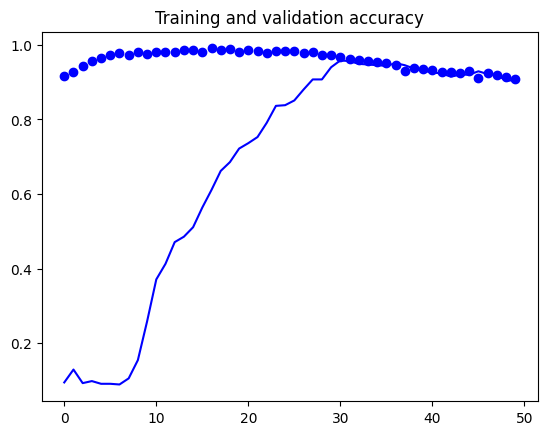

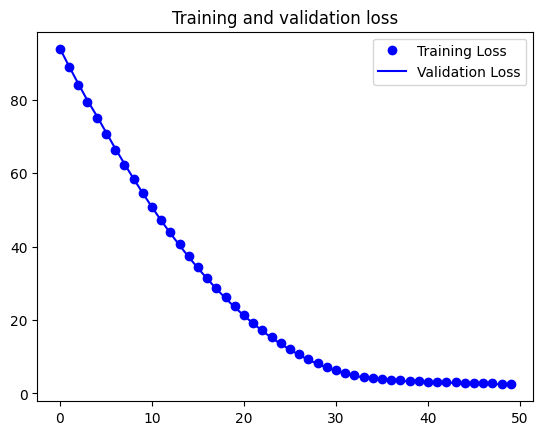

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 1s 27ms/step - loss: 2.4315 - accuracy: 0.9182


[2.431452751159668, 0.918181836605072]

In [22]:
import matplotlib.pyplot as plt

# Get predictions for test set
y_pred = model.predict(X_test)

# Display 4 sample predictions with class names
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
axs = axs.ravel()

for i in range(30):
    axs[i].imshow(X_test[i])
    true_class = class_names[y_test[i]]
    pred_class = class_names[np.argmax(y_pred[i])]
    axs[i].set_title(f"True: {true_class}\nPred: {pred_class}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 58ms/step


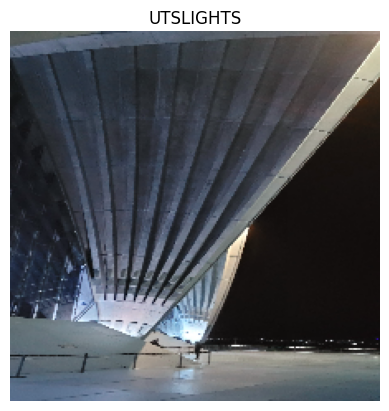

In [ ]:
ipath = '/content/drive/Shareddrives/Deep_Learning_A3/Vivid_Raw/Raw_Images/20230411_195943.jpg'


import cv2
import numpy as np

# Load the image and preprocess it
t = cv2.imread(ipath)
t = cv2.resize(t, (224, 224))  # resize to match input size of the model
t = t.astype("float32") / 255.0  # normalize pixel values

# Reshape the image to match the input shape of the model
t = np.reshape(t, (1, 224, 224, 3))

# Make the prediction
pred = model.predict(t)

# Get the predicted class index and name
class_index = np.argmax(pred[0])
class_name = class_names[class_index]

# Display the image with predicted class name
plt.imshow(t[0])
plt.title(class_name)
plt.axis('off')
plt.show()